# GPR1200 database - HandCrafted

## Autores: Benjamín Irarrázabal / Joaquín Zepeda

Este notebook reúne los códigos necesarios para calcular las medidas de similitud, el ranking y el ploteo de las imágenes similares a la consultada. \
Este considera las Features ya extraídas por las funciones definidas en otro Notebook (también entregado). Accediendo a ellas usando el directorio donde se ubican. \
Cabe destacar que este código de está corriendo localmente en Jupyter Notebook. \
**Ver Anexo de Informe para Instrucciones detalladas**

# Importamos librerías importantes

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance

# Abrimos el archivo de features guardado

In [2]:
import pickle
with open('GPR_Features_pkl' , 'rb') as f:
    GPR_Features = pickle.load(f)

In [3]:
GPR_Features

Name                                           Features
0      0_430b273cb7915d83  [3, 2, 3, 4, 6, 4, 16, 17, 18, 30, 53, 49, 99,...
1      0_618577ba46bc3d04  [61, 59, 72, 79, 148, 215, 350, 514, 688, 945,...
2      0_8684223b404f7e47  [179, 191, 333, 590, 1101, 1798, 2938, 4364, 5...
3      0_8c54ccf63a12ee74  [103, 43, 73, 92, 124, 206, 249, 374, 488, 682...
4      0_b904d301c9f168df  [111, 43, 79, 91, 172, 291, 453, 706, 905, 112...
...                   ...                                                ...
11995       599_sketch_26  [840, 267, 300, 234, 240, 285, 237, 282, 279, ...
11996       599_sketch_29  [739, 337, 265, 227, 152, 129, 110, 93, 88, 88...
11997       599_sketch_33  [606, 228, 216, 210, 243, 282, 261, 312, 318, ...
11998       599_sketch_34  [264, 81, 120, 156, 189, 219, 240, 384, 318, 4...
11999        599_sketch_6  [615, 171, 141, 111, 126, 159, 174, 177, 225, ...

[12000 rows x 2 columns]

# Medida de Similitud, Distancia Euclidiana

In [4]:
# A continuación, se define una función que toma un vector (para la imagen de consulta, img_q) y un conjunto de vectores (para las imágenes de database, img_d)
# y aplica la distancia entre vectores, devolviendo un nuevo vector con estas medidas de similitud
def distance_vector(img_q, img_d):
  """
  Cálculo del vector de distancia entre las características de una imagen y las
  características de todas las imágenes del database.

  :param numpy.ndarray img_q: Características
  :param pandas.DataFrame img_d: database de imágenes

  :return arreglo de numpy con distancias respectivas
  """
  # Se define una lista vacía que guarda las distancias entre vectores.
  Distance_vector = []
  # Se recorre el dataframe de características de database y se calcula la distancia.
  for i in range(len(img_d['Features'])):
    Distance = distance.euclidean(img_q, img_d['Features'].iloc[i])
    Distance_vector.append(Distance)
  # Se retorna un arreglo de numpy con el vector de distancias correspondiente.
  return np.array(Distance_vector)

# Ranking Normalizado

In [5]:
def rank_normalizado(img_q, Lista_Imagenes, database = GPR_Features):
  """
  Cálculo de Ranking Normalizado y ordenamiento de imágenes según relevancia

  :param string img_q: Nombre de la imagen consultada
  :param string Lista_Imagenes: Define si se quiere o no la lista de imágenes por orden de relevancia
  :param pandas.DataFrame database: Database de features

  :return Ranking Normalizado, Lista de imágenes relevantes, Número de imagenes relevantes para calcular la cantidad de aciertos.
  """
  # Se definen variables y listas.
  d_names = database['Name']
  Features = database['Features']
  N = len(d_names)-1 # 11999 (se descuenta uno por la imagen de consulta)
  Suma = 0
  class_img_q = img_q.split(sep='_')[0]
  # Iteración que busca las características y la posición de la imagen de consulta en la base de datos.
  for i in range(len(d_names)):
        if img_q == d_names.iloc[i]:
            feature_q = Features.iloc[i]
            posicion_img_q = i
            
  # Se buscan los mínimos dentro del vector de distancias calculado.
  D_vector = distance_vector(feature_q, database)
  posiciones = []
  arr = D_vector.copy()
  arr = sorted(arr)
  minimos = arr[1:20] # Nos saltamos el primero, que será el de la imagen de consulta (distancia 0)
  # Se guardan las posiciones de los mínimos encontrados
  for numero in minimos:
    for i in range(len(D_vector)):
      if numero == D_vector[i] and ((i in posiciones) == False):
        posiciones.append(i)
  
  # No es necesario calcular iterativamente Nrel, debido a que la base de datos está balanceada,
  # por lo tanto, cuando consultamos por una imagen automáticamente quedan 9 imágenes disponibles en el dataset
  Nrel = 9
  # Cálculo de Constante.
  Constant = Nrel*(Nrel+1)/2
  for i in range(Nrel):
    Suma += (posiciones[i]-Constant)
    
  # Se realiza el retorno de la función dependiendo de lo escogido.
  if Lista_Imagenes == 'Si':
    Name_imagenes = []
    for posicion in posiciones:
      Name_imagenes.append(d_names.iloc[posicion])
    return (Suma/(Nrel*N)), Name_imagenes[0:10], Nrel

  elif Lista_Imagenes == 'No':
    return (Suma/(Nrel*N))
  else:
    print('Por favor revise los parámetros ingresados')

In [11]:
# La siguiente función busca aplicar el rank normalizado a todas las imágenes de un respectivo frame entregado.
def rank_normalized_frame(img_q):
  """
  Devolver frame con todos los rankings y su imagen de consulta asociada.

  :param pandas.DataFrame img_q: Features del database (GPR_Features)

  :return DataFrame con los nombres de las imágenes de consulta y su respectivo ranking
  """
  names = img_q['Name']
  ranking_N_frame = pd.DataFrame(columns=['Name', 'Rank'])
  # Se aplica rank_normalizado recorriendo todas las imágenes de consulta y se guardan en un DataFrame.
  for i in range(len(names)):
    Rank = rank_normalizado(names.iloc[i], Lista_Imagenes='No')
    ranking_N_frame = ranking_N_frame.append({'Name': names.iloc[i], 'Rank': Rank}, ignore_index=True)
  return ranking_N_frame

In [25]:
import time
inicio = time.time()
RankGPR_HC = rank_normalized_frame(GPR_Features)
fin = time.time()
print(fin-inicio)

3892.240769147873


In [26]:
RankGPR_HC

Name      Rank
0      0_430b273cb7915d83  0.420368
1      0_618577ba46bc3d04  0.337343
2      0_8684223b404f7e47  0.314285
3      0_8c54ccf63a12ee74  0.247169
4      0_b904d301c9f168df  0.298655
...                   ...       ...
11995       599_sketch_26  0.899519
11996       599_sketch_29  0.674010
11997       599_sketch_33  0.902094
11998       599_sketch_34  0.566964
11999        599_sketch_6  0.898908

[12000 rows x 2 columns]

In [30]:
# create an iterator object with write permission
with open('RankGPR_HC_pkl', 'wb') as file:
    pickle.dump(RankGPR_HC, file)

In [14]:
def plot_rank(img_q):
    """
    Plotear imagen de consulta y las asociadas al ranking

    :param string img_q: Nombre de una imagen de consulta

    :return plot_images, print(cantidad de aciertos)
    """
    # Aplicamos Rank_Normalizado a la imagen de consulta, encontrando las imágenes más similares en el database.
    Rank, L, Nrel = rank_normalizado(img_q, Lista_Imagenes='Si')
    # Buscamos la imagen en una de las dos carpetas del database, jpg1 o jpg2 y se le aplica plot.
    try:
        img = cv2.imread("GPR1200//images/" + img_q + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagen Consultada: ' + img_q)
    except:
        img = cv2.imread("GPR1200//images/" + img_q + ".jpeg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagen Consultada: ' + img_q)
    # Se realiza un conjunto de 10 imágenes para mostrar el ranking
    fig = plt.figure(figsize=(15, 15))
    rows = 5
    columns = 2
    number = 1
    # Se define una cantidad de aciertos para registrar el desempeño de la búsqueda.
    Aciertos = 0
    # Se plotean las imágenes asociadas al ranking buscándolas en jpg1 o jpg2.
    for name in L:
        try:
            fig.add_subplot(rows, columns, number)
            img = cv2.imread("GPR1200//images/" + name + ".jpg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Ranking '+ str(number)+', '+ name)
            number += 1
            if (img_q.split(sep='_'))[0] == (name.split(sep='_'))[0]:
              Aciertos += 1
        except:
            fig.add_subplot(rows, columns, number)
            img = cv2.imread("GPR1200//images/" + name + ".jpeg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Ranking '+ str(number)+', '+ name)
            number += 1
            if (img_q.split(sep='_'))[0] == (name.split(sep='_'))[0]:
              Aciertos += 1
    # Se imprime la cantidad de aciertos del algoritmo, ie, 
    # cantidad de imágenes con la misma clase que la imagen consultada
    print('Cantidad de Aciertos: ' + str(Aciertos) +' de '+ str(Nrel))

# Ejemplos Cualitativos para el Extractor Clásico

Cantidad de Aciertos: 1 de 9


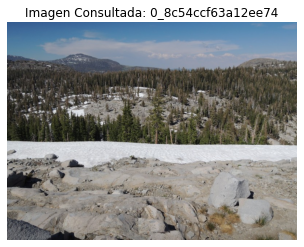

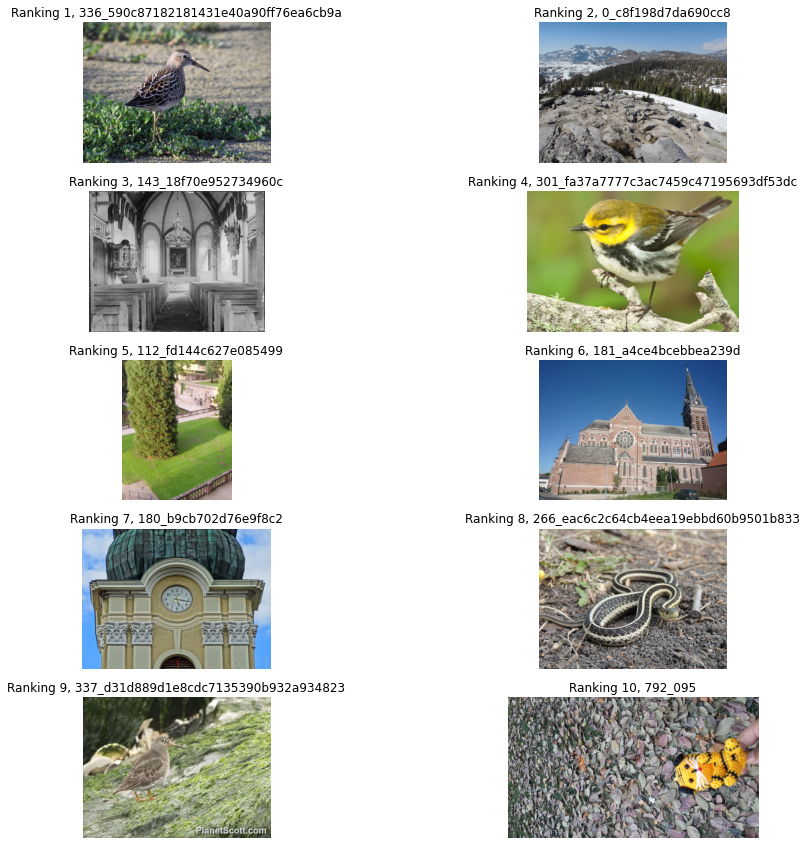

In [15]:
plot_rank('0_8c54ccf63a12ee74')

Cantidad de Aciertos: 0 de 9


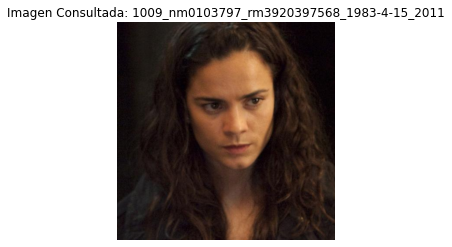

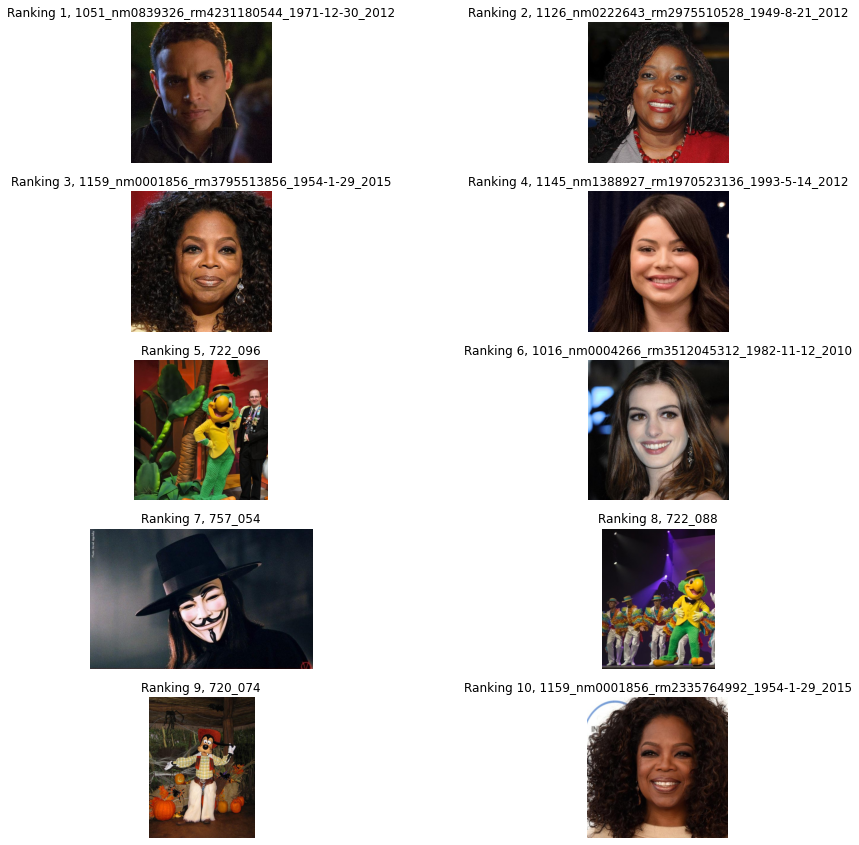

In [16]:
plot_rank('1009_nm0103797_rm3920397568_1983-4-15_2011')

Cantidad de Aciertos: 0 de 9


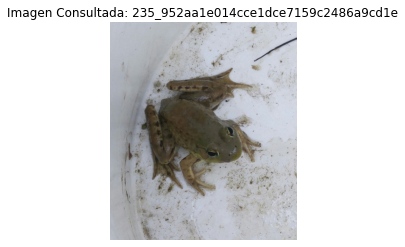

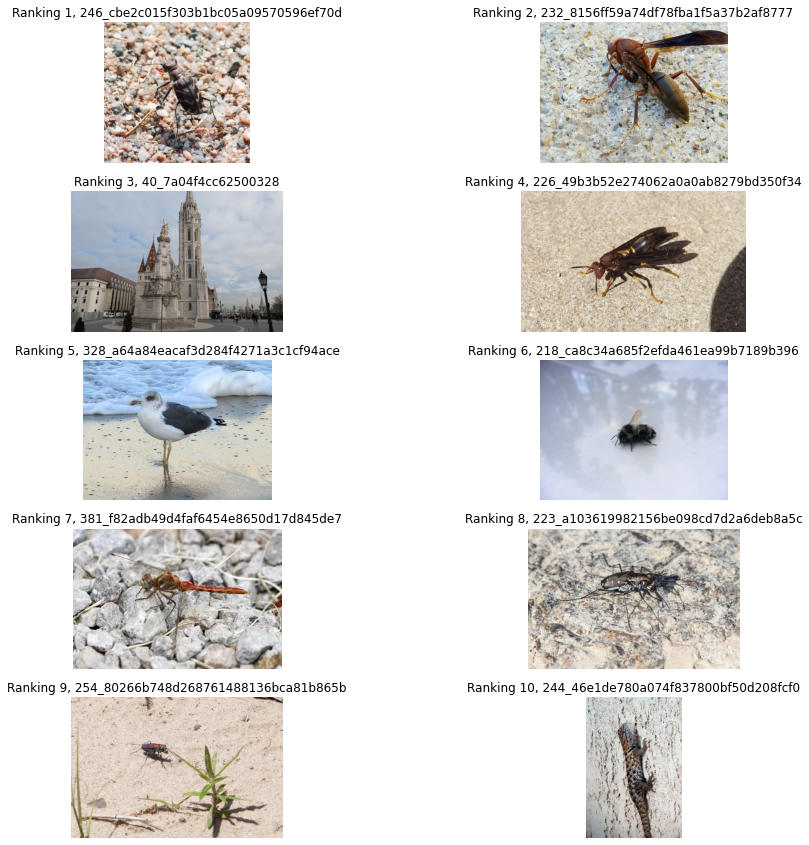

In [17]:
plot_rank('235_952aa1e014cce1dce7159c2486a9cd1e')

Cantidad de Aciertos: 1 de 9


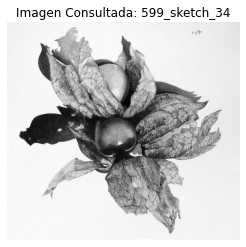

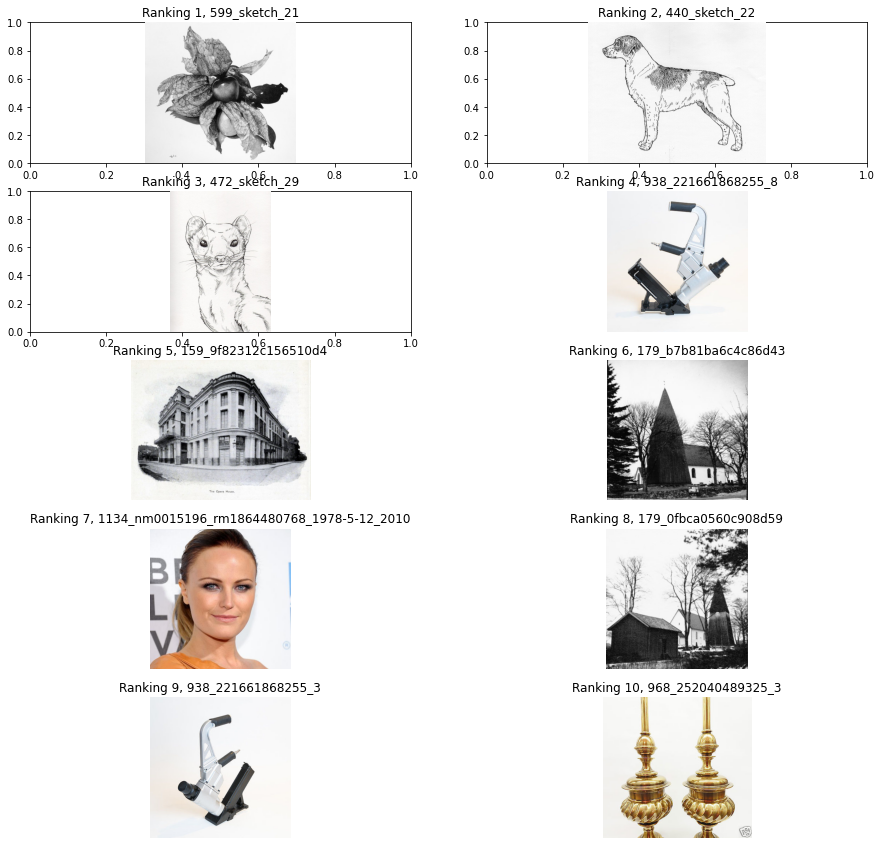

In [18]:
plot_rank('599_sketch_34')

Cantidad de Aciertos: 2 de 9


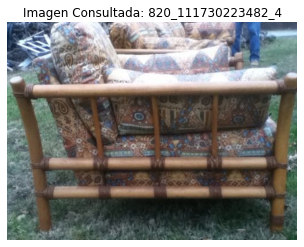

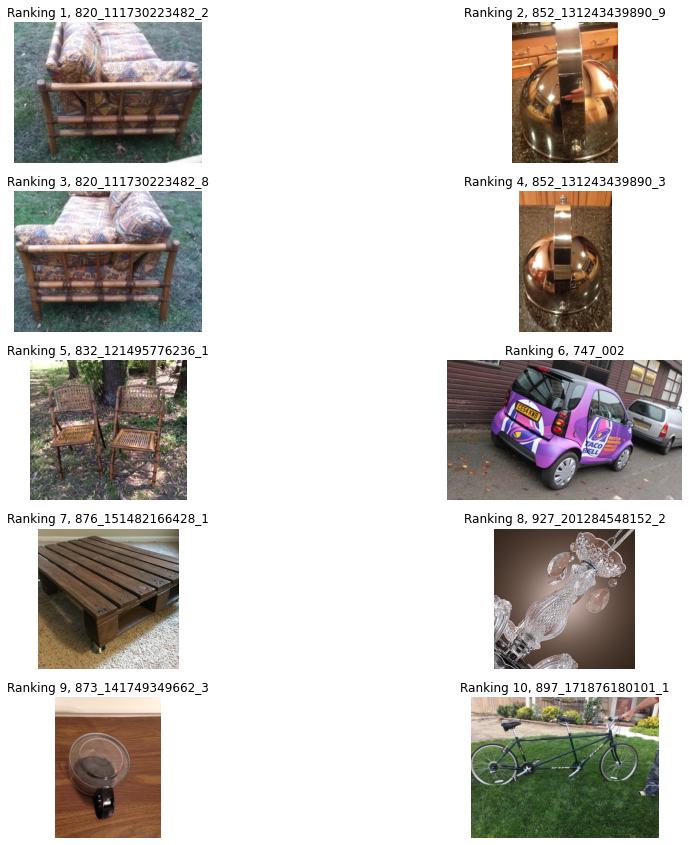

In [19]:
plot_rank('820_111730223482_4')

Cantidad de Aciertos: 4 de 9


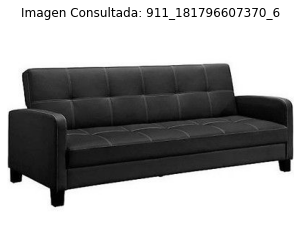

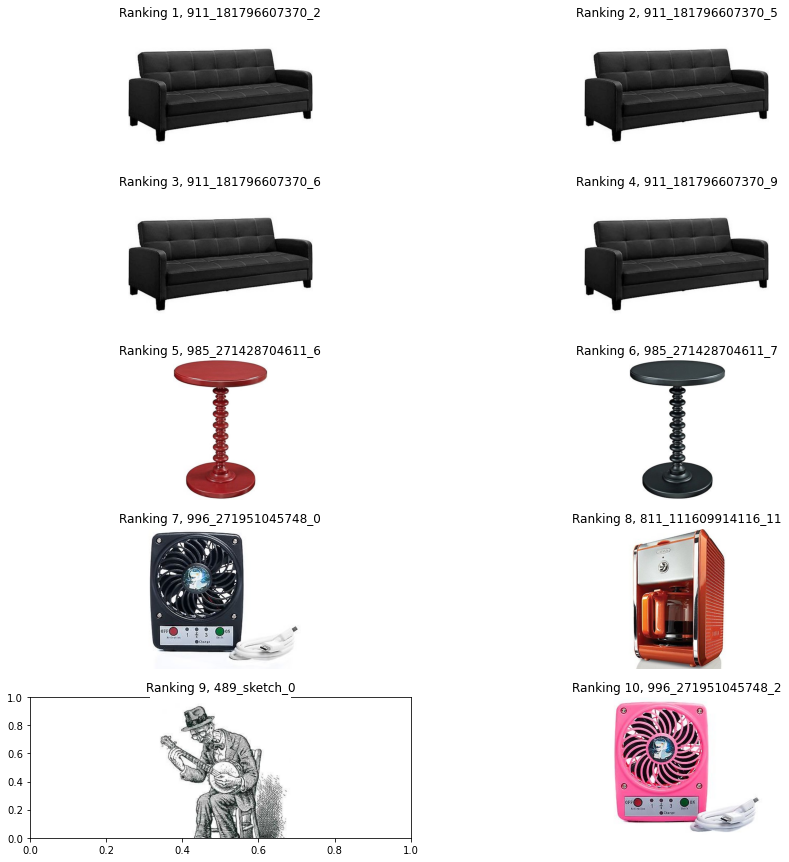

In [20]:
plot_rank('911_181796607370_6')

Cantidad de Aciertos: 0 de 9


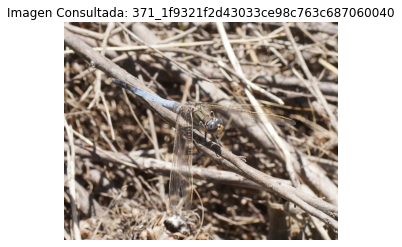

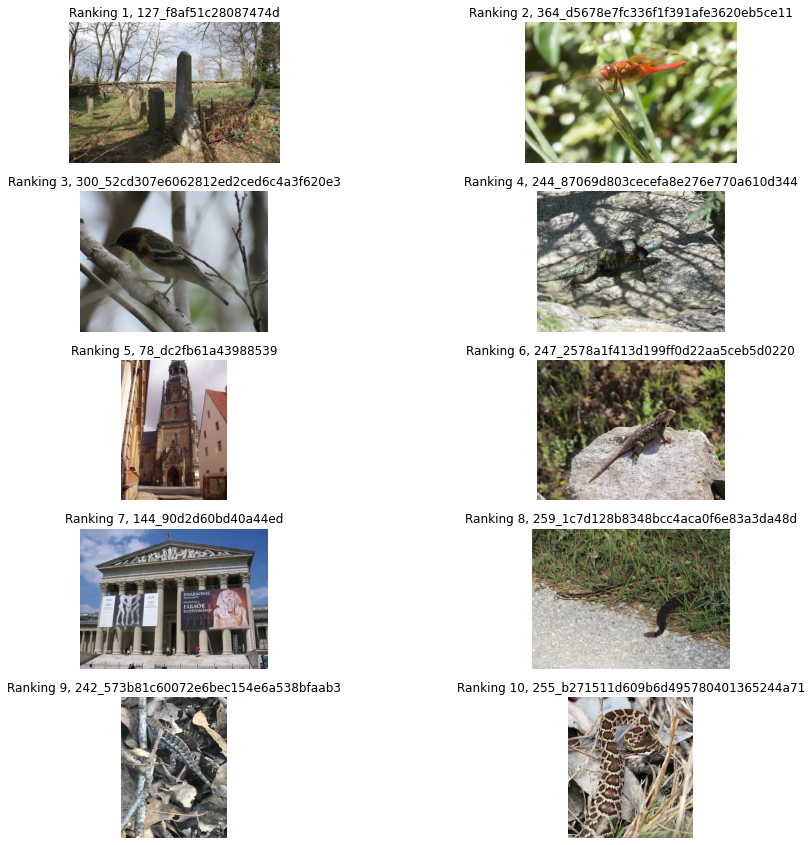

In [21]:
plot_rank('371_1f9321f2d43033ce98c763c687060040')

Cantidad de Aciertos: 0 de 9


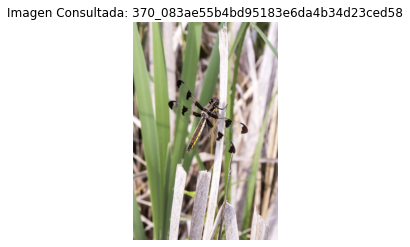

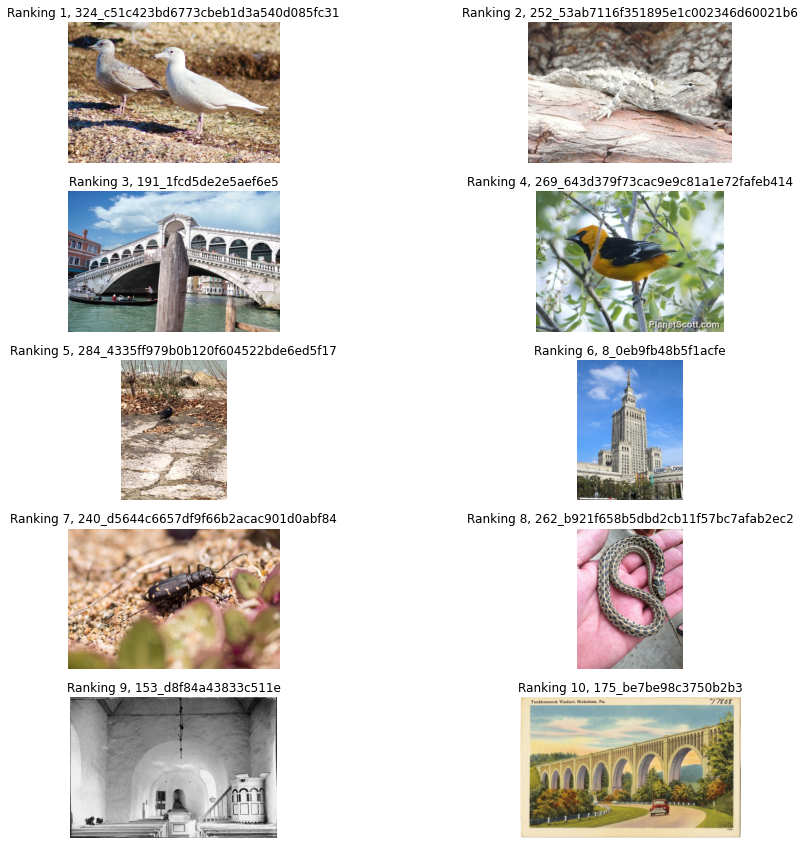

In [22]:
plot_rank('370_083ae55b4bd95183e6da4b34d23ced58')

Cantidad de Aciertos: 0 de 9


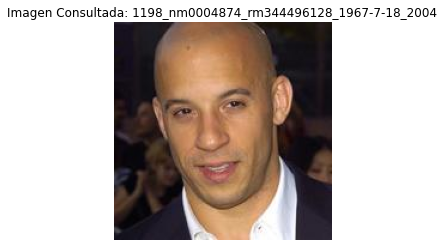

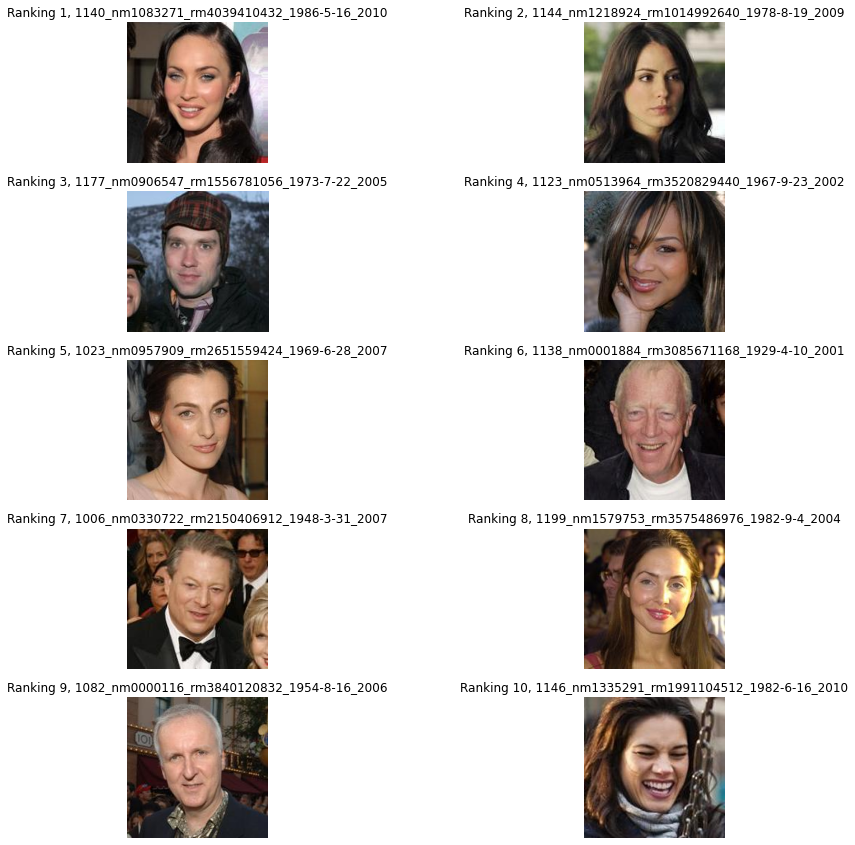

In [23]:
plot_rank('1198_nm0004874_rm344496128_1967-7-18_2004')